In [1]:
# modules

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.pardir)

from dataset.mnist import load_mnist
# 本書公式 GitHub (https://github.com/oreilly-japan/deep-learning-from-scratch) で提供されてるモジュール．
# カレントディレクトリに dataset をダウンロードして置いておく，
# あるいは普通にリモートリポジトリごと
# $ git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git
# でローカルに git clone しておく．

# from common.math_functions import *

# %load_ext rpy2.ipython
# rpy2 で R も使いたい場合↑


# 5章 誤差逆伝搬法

> [p123] なお、誤差逆伝播法を計算グラフによって説明するアイデアは、Andrej Karpathy のブログ [4] 、また、彼と Fei-Fei Li 教授らによって行われたスタンフォード大学の ディープラーニングの授業「CS231n」[5] を参考にしています。

[Andrej Karpathy](https://cs.stanford.edu/people/karpathy/) さんは Tesla の CV 系 AI 研究者で，ブログは[ここ](http://karpathy.github.io/neuralnets/)．PhD の指導教官が Stanford の [Fei-Fei Li](https://profiles.stanford.edu/fei-fei-li?tab=bio) さんで，この方は GoogleCloud で Chief Scientist してたらしい．

# 5.1. 計算グラフ

> [p123] 計算グラフとは、計算の過程をグラフによって表したものです。ここで言うグラフ とは、データ構造としてのグラフであり、複数のノードとエッジによって表現されます
 
計算グラフは「演算のフローを可視化したグラフ」という感じ．

> [p124] 計算グラフはノードと矢印によって計算の過程を表します。ノードは○で表記し、 ○の中に演算の内容を書きます。また、計算の途中結果を矢印の上部に書くことで、 ノードごとの計算結果が左から右へ伝わるように表します。

前述のニューロンのグラフ (図3-18とか) ではノードが「変数(入力,特徴量,出力)」で矢印が「変換(写像)」というイメージだったが，ここの計算グラフ(図5-3とか)では逆でノードが「演算(変換,写像)」で矢印が「変数(入力,特徴量,出力)」というイメージ．混同しないように．

> [p126] ここまで見てきたように、計算グラフを使って問題を解くには、
1. 計算グラフを構築する
2. 計算グラフ上で計算を左から右へ進める
>
>という流れで行います。ここで 2 番目の「計算を左から右へ進める」というステップは、順方向の伝播、略して、**順伝播**(forward propagation)と言います。順伝播は、計算グラフの出発点から終着点への伝播です。順伝播という名前があるのであれば、逆方向――図で言うと、右から左方向へ――の伝播も考えることができるでしょう。実際、それを**逆伝播**(backward propagation)と言います。逆伝播は、この先、 微分を計算するにあたって重要な働きをします。

そもそも計算グラフは「演算の過程を左スタート右ゴールで可視化したもの」なので，左から右へ計算を進める過程を「順伝搬」と呼ぶのは自然．

> [p127] たとえば、リンゴとそれ以外の買い物を合計する計算―― 4,000 + 200 → 4,200――は、4,000 という数字がどのように計算されてきたかということについては考えずに、ただ 2 つの数字を足せばよいということを意味します。言い換えれば、各ノードの計算で行うべきことは、自分に関係する計算――この例では、入力された 2 つの数字の足し算――だけであり、 全体のことについては何も考えなくてよいのです。
このように、計算グラフでは、局所的な計算に集中することができます。たとえ全体の計算がどんなに複雑であったとしても、各ステップでやることは、対象とするノードの「局所的な計算」なのです。局所的な計算は単純ですが、その結果を伝達することで、全体を構成する複雑な計算の結果が得られます。... 計算グラフも、複雑な計算を「単純で局所的な計算」に分割して、流れ 作業を行うように、計算の結果を次のノードへと伝達していきます

計算グラフのこのメリットは，関数型プログラミングパラダイムのメリットと似ている．大きい処理を細かい関数に分けることで，各関数の入出力の仕様だけに注意を払って実装とか単体テストができるようになり，気持ちが楽でミスりづらいしデバッグしやすい．

> [p128] ここでは、リンゴの値段に関する微分だけを求めましたが、「消費税に関する支払金額の微分」や「リンゴの個数に関する支払金額の微分」も同様の手順で求めることができます。そして、その際には、途中まで求めた微分(途中まで流れた微分)の結果を共有することができ、効率良く複数の微分を計算することができるのです。

ここが back propagation の肝だと思う．途中までの微分の結果を共有できるので，無駄が削られ計算コストが下がる．

電気信号回路(ニューロン)でふわっとしたイメージすると...  
これまでのナイーブな勾配算出法は，
- 第1層の各ニューロンから出る信号をちょっと強めて，最後の信号 (出力層から出た信号をロス関数に入れて出る信号) がどのくらい変化するか見る．それで第1層の偏微分係数ゲット．
- 第2層の各ニューロンから出る信号をちょっと強めて，最後の信号がどのくらい変化するか見る．それで第2層の偏微分係数ゲット．
- ...

という感じ．ここでポイントなのが，例えば第 $n-1$ 中間層と第 $n$層(出力層)の間には，何度も(全パラメータ数分)だけ信号が流れている．  
一方，誤差逆伝搬では，

- 第 $n-1$ 層の各ニューロンから出る信号をちょっと強めて，最後の信号がどのくらい変化するか見る．それで第 $n-1$ 層の偏微分係数ゲット．そしてその情報を記録してとっておく．
- 第 $n-2$ 層の各ニューロンから出る信号をちょっと強めて，次の第 $n-1$ 層に入る信号がどのくらい変化するかを見る．それを先ほど記録した $n-1$ 層の偏微分係数に掛け合わせて，第 $n-2$ 層の変微分係数を取得．この情報も記録しておく．
- ...

という感じ．連鎖律を使ったことで，例えば先ほどの方法だと何度も信号が流されていた $n-1$ 層と $n$ 層の間に，１回だけしか信号が流れていない．無駄を削ぎ落とせている．

もっと正確に説明する．重みパラメータはニューロン間の繋がりの強さ(通路,チャネルの太さ)で，最初の input 信号が生の説明変数値，最後の output 信号がロス関数値，みたいなイメージを持って．
なので目標は「最初に input される信号 (ロス算出対象データ) はもう決まっていて固定で，各チャネルの太さを若干変化させた時に最後に output される信号がどう変化するか調べる」こと．

これまでのナイーブな勾配算出法は，どの層のチャネルについて調べる時も全く同じことをする．「そのチャネルをちょっと細くして (-h ずらして) 最初から入力信号をフルでforwardで流して，次はチャネルとちょっと太くして (+hずらして) 同じことをして，変化率を計算」という繰り返し作業を，全チャネルに対してやる．確実だが賢くなく効率が悪い．

一方， back propagation ではさっきとは違って，層ごとに取り扱い方を変えたり工夫して賢く調べていく．

- はじめに１回だけフルで forward 方向に信号を流し，その時に各チャネルに流れた(各ノードから出た)信号の強さとかを記録して保持しておく．
- そのあとまず，第$n$層のニューロンから先ほどより少しだけ変化させた信号を出してロス関数に渡して，ロス値がどう変化するかを記録(1)．
- 次に，第 $n$ 層のチャネルの太さをちょっと変えて第$n-1$層のニューロンから最初のforward時と同じ強さの信号を流して第$n$層に伝わる信号の変化を記録する．これを(1)と掛け合わせることで第 $n$ 層のチャネルの太さの変化がロス値にどういう変化をもたらすか見積もれるはず(chain rule,直感的に考えても納得)なので算出，目的の一部達成．
- 後のために，今度は $n$ 層のチャネルの太さはそのまま固定して第$n-1$層のニューロンから最初のforward時から少し変化させた強さの信号を流して第$n$層に伝わる信号の変化を記録する(2)
- 次に，第 $n-1$ 層のチャネルの太さをちょっと変えて第$n-2$層のニューロンから最初のforward時と同じ強さの信号を流して第$n-1$層に伝わる信号の変化を記録する．これを(1)(2)と掛け合わせることで第 $n-1$ 層のチャネルの太さの変化がロス値にどういう変化をもたらすか見積もれるはず(chain rule,直感的にも納得)なので算出．目的の一部達成．
- 後のために，今度は $n-1$ 層のチャネルの太さはそのまま固定して第$n-2$層のニューロンから最初のforward時から少し変化させた強さの信号を流して第$n-1$層に伝わる信号の変化を記録する(3)．
- 次に，第 $n-2$ 層のチャネルの太さをちょっと変えて第$n-3$層のニューロンから最初のforward時と同じ強さの信号を流して第$n-2$層に伝わる信号の変化を記録する．これを(1)(2)(3)と掛け合わせることで第 $n-2$ 層のチャネルの太さの変化がロス値にどういう変化をもたらすか見積もれるはず(chain rule,直感的にも納得)なので算出．目的の一部達成．
- 後のために，今度は $n-1$ 層のチャネルの太さはそのまま固定して第$n-2$層のニューロンから最初のforward時から少し変化させた強さの信号を流して第$n-1$層に伝わる信号の変化を記録する(4)．
- ...

という感じ．明らかにナイーブな方法より，チャネルを通る信号の総量が少ない．つまりやるべき行列計算の量が少ない．



# 5.2. 連鎖律

計算グラフのノードは

- 左から入力された信号に対しては，その値をノード関数で変換して結果を右に出力する
- 右から入力された信号に対しては，それにノード関数の微分を掛け合わせて左に出力する

という挙動を示す(ことにしている)．そうすると色々便利だから．

> [p131] 図 5-7 で注目すべきは、一番左の逆伝播の結果です。これは、連鎖律より、
...「x に関する z の微分」に対応します。つまり、逆伝播が行っていることは、連鎖律の原理から構成されているのです。

もはや計算グラフは「合成関数の微分を分かりやすく求めるためのツール」とも捉えられそう．普通に微積のテストとかでも役立ちそう．

少し違っていて注意しないといけないのは， SGD においては「合成関数の導関数」ではなく 「合成関数の微分係数」という１点の値を求めようとしてる，ということ．

# 5.3. 逆伝搬

> [p132] なお、この例では上流から伝わった微分の値を $\frac{\partial L}{\partial z}$ としましたが、これは図5-10に示すように、最終的に $L$ という値を出力する大きな計算グラフを想定しているため

NN の SGD とかでは「各パラメータをちょっと動かした時にロス $L$ がどのくらい変化するか」という勾配を求めようとするので，計算グラフの最後には必ず，ロス $L$ を出力するロス関数ノードがあるはず．

# 5.4. 単純なレイヤの実装

> 次節では、ニューラルネットワークを構成する「層(レイヤ)」をひとつのクラスで実装することにします。ここで言う「レイヤ」とは、ニューラルネットワー クにおける機能の単位です。たとえば、シグモイド関数のための Sigmoid や、 行列の積のための Affine など、レイヤ単位で実装を行います。そのため、こ こでも「レイヤ」という単位で、乗算ノードと加算ノードを実装します。

次節以降 (例えば図5-28) では，当初の俺が思ってた通り変換 (変数じゃなくて) を層 (レイヤー) とみなしている．このグラフでは変換がノードで表されててノード群を層と見るのは視覚的に直感的．この捉え方なら $n$ 層ニューラルネットワークっていう用語も「$n$ 回(層)の変換を行う NN」と解釈できて，分かりやすい．

そう考えると，前述の図3-18みたいな「変数がノードで変換が矢印」のグラフより，後述の図5-14~5-30みたいな「変数が矢印で変換がノード」のグラフの方が「層(レイヤー)」のイメージがつきやすくて良いかも．まあ，どっちの見方もできるようにしとくのが良い．

計算グラフは NN を実装する上での良い設計図になっているってことか．ノード(あるいは複数ノードをまとめたレイヤー)を class で実装して，そのインスタンスを組み合わせることで NN 全体を実装できるから．Pytorch もそんな感じだった．

In [129]:
# 乗算レイヤの実装 (5.4.1 / p137)

class MulLayer:
    """掛け算レイヤを表すクラス
    
    f(x,y) = xy という変換に対応するクラス．
    計算グラフのノードをそのまま実装するイメージ．
    
    Attributes:
      x: 掛け算関数f(x,y) = x*y の x．
      y: 同じく． のちの NN では，更新が繰り返されるパラメータ値が状態として保存されている．
    """
    
    def __init__(self):
        """ initialize
        
        アトリビュートの初期化を __init__() ではなく forward() メソッドでやる理由
        ニューラルネットで逆伝搬する時のフローをイメージしてる．
        １回だけ予測値とロスを算出して(forward して)，
        そこから戻りながら勾配を計算していく(backward する)というフローが採られるので，
        それを想定して最初の forward 時にアトリビュートの初期化が起こるように書いてある．
        
        """
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        """掛け算レイヤの forward 処理
        
        つまり，ただ掛け算を実行して結果を出力する．
        ここでアトリビュート(状態)の初期化や更新が行われる理由は，↑を参照．
        
        Returns:
          - self.x * self.y
        
        """
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        """掛け算レイヤの backward 処理
        
        つまり，状態 x,y に保存されている値での掛け算関数の勾配を計算する．
        つまり，座標(self.x, self.y)における掛け算関数の勾配を計算する．
        さらに(計算グラフ上の右から)入力された値 dout に算出された勾配を掛け合わせる．
        そしてそれを出力する．
        
        Returns:
          - self.x における f(x,y)=x*y の偏微分係数(勾配)
          - self.y における f(x,y)=x*y の偏微分係数(勾配)        
        
        """
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [3]:
# ↑で定義した掛け算レイヤの動作確認

# get layer

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()
# 各レイヤ(計算グラフのノード)ごとのオブジェクトを作成．


# forward

apple_price = 100
apple_num = 2
tax = 1.1

apple_sum = mul_apple_layer.forward(x=apple_price, y=apple_num)
print(apple_sum)  # forward 伝搬での出力
print(mul_apple_layer.x, mul_apple_layer.y)  # 状態に forward 伝搬での入力が記録されている

total_pay = mul_tax_layer.forward(x=apple_sum, y=tax)
print(total_pay)  # forward 伝搬での出力
print(mul_tax_layer.x, mul_tax_layer.y)  # 状態に forward 伝搬での入力が記録されてる


# backward

dtotal_pay = 1
# いまの合成関数全体の最終出力は total_pay で，
# backward に　chain rule で勾配を求めていく都合上，
# 最初に d(total_pay) / d(total_pay) という自分自身による微分係数(常に１)を作っとく必要がある．

dapple_sum, dtax = mul_tax_layer.backward(dtotal_pay)
print(dapple_sum, dtax)
# apple_sum, tax の(forward 時に属性に記録した値での) (total_pay に対する) 偏微分係数を算出．
# これはノードから左方向(逆方向)に吐き出されるイメージ．
# d(total_pay) / d(apple_sum)  と  d(total_pay) / d(tax)　という感じ．
# 最終出力(目的関数値) total_pay に直接影響してる変数なので， chain rule は活用してない．

dapple_price, dapple_num = mul_apple_layer.backward(dapple_sum)
print(dapple_price, dapple_num)
# apple_price, apple_num の (属性に記録された値での) (total_payに対する) 変微分係数を取得．
# これはノードから左方向(逆方向)に吐き出されるイメージ．
# ここで，実際に中身で計算されているのは
# d(apple_sum) / d(apple_price)  と  d(apple_sum) / d(apple_num)  だけで，
# この２つに右からの入力で渡した dapple_sum == d(total_pay) / d(apple_sum) を掛けて，
# d(apple_sum) / d(apple_price) × d(total_pay) / d(apple_sum)
#  = d(apple_price) / d(total_pay) という感じで．
# 連鎖律(合成関数微分，chain rule) を活用して楽に算出している．

200
100 2
220.00000000000003
200 1.1
1.1 200
2.2 110.00000000000001


In [130]:
# 足し算レイヤの実装


class AddLayer:
    """足し算レイヤ
    
    f(x, y) = x + y の変換に対応するレイヤ
    
    Attributes:
      x: 足し算レイヤに左から入力された x つまり f(x,y) = x + y の x．
      y: 同じく． forward() では足し算に使われ， backward() では勾配を求めたい座標となる．
          NN では繰り返し更新され続けるパラ値が状態として記録される．
    
    """
    
    def __init__(self):
        """ initialize
        
        初期化．
        
        """
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        """ forward propagation
        
        足し算を実行して右方向に出力．
        
        """
        self.x = x
        self.y = y
        return x + y
    
    def backward(self, dout):
        """ backward propagation
        
        アトリビュートに保存された座標での足し算関数に対する勾配を算出し，
        それを dout に chain rule で掛け合わせ， 左へ出力．
        
        Note:
          掛け算レイヤの時と違って，偏微分係数は座標によらず一定である．
          なので， self.x と self.y に forward 時の入力を記録しておく必要も，今回は無い．
          ただまあ，一般的には座標によって勾配違うので，ちゃんと self.x,y に記録することにする．
        
        """
        dx = 1 * dout  # d(final) / d(x)  =  d(out) / d(x) * d(final) / d(out)
        dy = 1 * dout  # d(final) / d(y)  =  d(out) / d(y) * d(final) / d(out)
        return dx, dy

In [5]:

# makeup Layers

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_fruit_layer = AddLayer()
mul_tax_layer = MulLayer()


# forward propagation

apple_num = 2
apple_price = 100
orange_num = 3
orange_price = 150
tax = 1.1

apple_sum = mul_apple_layer.forward(x=apple_num, y=apple_price)
orange_sum = mul_orange_layer.forward(x=orange_num, y=orange_price)
fruit_sum = add_fruit_layer.forward(x=apple_sum, y=orange_sum)
total_pay = mul_tax_layer.forward(x=fruit_sum, y=tax)
print(apple_sum, orange_sum)
print(fruit_sum)
print(total_pay)


# backward propagation

d_total_pay = 1    #  d(total_pay) / d(total_pay)

d_fruit_sum, d_tax = mul_tax_layer.backward(dout=d_total_pay)
print( d_fruit_sum, d_tax)
#  d(total_pay) / d(fruit_sum)  と  d(total_pay) / d(tax)

d_apple_sum, d_orange_sum = add_fruit_layer.backward(dout=d_fruit_sum)
print( d_apple_sum, d_orange_sum )
#  d(total_pay) / d(apple_sum)
#    =  d(total_pay) / d(fruit_sum)  *  d(fruit_sum) / d(apple_sum)
#  d(total_pay) / d(orange_sum)
#    = d(total_pay) / d(fruit_sum)  * d(fruit_sum) / d(orange_sum)

d_apple_num, d_apple_price = mul_apple_layer.backward(dout=d_apple_sum)
print( d_apple_num, d_apple_price )
#  d(total_pay) / d(apple_num)
#    = d(total_pay) / d(apple_sum)  *  d(apple_sum) / d(apple_num)
# d(total_pay) / d(apple_price)
#    = d(total_pay) / d(apple_sum) * d(apple_sum) / d(apple_price)

d_orange_num, d_orange_price = mul_orange_layer.backward(dout=d_orange_sum)
print( d_orange_num, d_orange_price )
#  d(total_pay) / d(orange_num)
#    = d(total_pay) / d(orange_sum)  *  d(orange_sum) / d(orange_num)
#  d(total_pay) / d(orange_price)
#    = d(total_pay) / d(orange_sum)  *  d(orange_sum) / d(orange_price)

200 450
650
715.0000000000001
1.1 650
1.1 1.1
110.00000000000001 2.2
165.0 3.3000000000000003


> 図 5-17

計算グラフでは変数が矢印で表現されているが，

- forward 矢印にはその変数の値
- backward 矢印にはその変数の値における最終出力の勾配(偏微分係数)

が対応している．そう捉えると分かりやすい．

# 5.5. 活性化関数レイヤの実装

> それでは、計算グラフの考え方をニューラルネットワークに適用したいと思います。ここでは、ニューラルネットワークを構成する「層(レイヤ)」をひとつのクラスとして実装することにします。

ここでの層(レイヤ)は NN の変換(アフィン, 活性化など)のことを指してる．最初の方(図 2-13, 図3-1とか)ではニューロン群を層と見做していたが，今は違う．まあどっちの見方もメリットがある (前者は back/forward propagation の実装がしやすく，後者は神経ネットワーク的な感じで分かりやすい)ので，どっちもできるように．

## 5.5.1.  ReLU レイヤ

In [2]:
# ReLU 活性化関数クラスの実装

class ReLU:
    """ ReUL layer
    
    テキストの実装から自分好みに変えてる
    
    """
    
    def __init__(self):
        """ initialize
        """
        self.x = None
    
    def forward(self, x):
        """ forward propagation
        
        activate vector x by ReLU function.
        
        """
        self.x = x
        out = np.where(x >= 0, x, 0)
        return out
    
    def backward(self, dout):
        """ backward propagation
        
        calcurate gradient by using chain rule.
        d(loss) / d(x)  =  d(loss) / d(out)  *  d(out) / d(x)
        
        """
        dx = np.where(self.x >= 0, 1, 0)
        return dout * dx

In [3]:
# ↑の ReLU クラスの動作確認

relu_layer = ReLU()
print( relu_layer.forward(x=np.array([-0.4, 2.1, -10, 12.1])) )
print( relu_layer.backward(dout=10) )

[ 0.   2.1  0.  12.1]
[ 0 10  0 10]


In [4]:
# ↑の ReLU クラス実装の試行錯誤

x = np.array([0.9, -0.4, 0.5, -0.3])
x >= 0
print( np.where(x >= 0, x, 0) )
# https://note.nkmk.me/python-numpy-where/

%R x <- c(0.9, - 0.4, 0.5, - 0.3)
%R print( ifelse(x >= 0, x, 0) )


print( np.where(x >= 0, 1, 0) )
%R print( ifelse(x >=0, 1, 0))

[0.9 0.  0.5 0. ]


[1] 0.9 0.0 0.5 0.0


[1 0 1 0]


[1] 1 0 1 0


## 5.5.2.  Sigmoid レイヤ

$$
\begin{aligned}
\frac{dy}{dx}
&= \frac{d}{dx} \left[ \frac{1}{1 + \exp(-x)} \right] \\
&= -1 * \left(1 + \exp(-x) \right)^{-2}
 \frac{d}{dx} [1+\exp(-x)]  \\
&= \left(1 + \exp(-x) \right)^{-2} \exp(-x)  \\
&= \frac{1}{1 + \exp(-x)} \frac{\exp(-x)}{1 + \exp(-x)} \\
&= \frac{1}{1 + \exp(-x)} \left( 1 - \frac{1}{1 + \exp(-x)} \right) \\
&= y~(1-y)
\end{aligned}
$$

In [3]:
# Sigmoid レイヤの実装

class Sigmoid:
    """ sigmoid layer
    
    テキストの実装から自分好みに少し変えてる．
    
    """
    
    def __init__(self):
        """ initialize 
        """
        x = None
    
    def forward(self, x):
        """ forward propagation
        
        勾配 d(out) / d(x) を計算する際，↑で確認したように，
        シグモイドの入力 x を使うより出力 y を使った方が簡単に済む．
        なので， self.x = x として x を記録しておくのではなく，　out　の方を記録しておいて，
        それを backward() の時に使うようにする．
        
        """
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        """ backward propagation 
        
        ↑で確認したように解析的に勾配 d(out) / d(x) が求まる．
        chain rule を使って
        d(loss) / d(x)  =  d(loss) / d(out)  *  d(out) / d(x)
        を算出して返す．
        
        """
        dx = self.out * (1.0 - self.out)
        return dout * dx

In [6]:
# ↑の Sigmoid クラスの動作確認

sigmoid_layer = Sigmoid()
print( sigmoid_layer.forward(np.array([-0.3, +0.3, 0.0, -2.0, +2.0])) )
print( sigmoid_layer.backward(dout=1) )

[0.42555748 0.57444252 0.5        0.11920292 0.88079708]
[0.24445831 0.24445831 0.25       0.10499359 0.10499359]


# 5.6. Affine / Softmax レイヤの実装

## 5.6.1. Affine レイヤ

> [p147] ニューラルネットワークの順伝播で行う行列の積は、幾何学の分野では「アフィン変換」と呼ばれます。

アフィン変換は線形変換と平行移動を組み合わせたもの．数式で言うと，$x$ のアフィン変換は $A x + b$ と言う感じ． 2次元から2次元とか，3次元から3次元のアフィン変換は幾何学的な解釈が可能で，ベクトル(図形)の回転＆拡大縮小＆平行移動みたいなイメージ．PRML のガウス分布のとこでやった「基底ベクトルを列とした行列の逆行列をかけると，その規定ベクトルの座標軸での成分に変換できる」とかも思い出して．

> [p148] 式 (5.13) が導かれる過程はここでは省略します

ここやってみる．行列積レイヤの逆伝搬を導く，つまり $W, x$ を変数としたロス関数値 $l$ の勾配を導く．ここで $l$ は $a_1, a_2, \ldots, a_n$ の関数．ポイントとしては，変数をノードとした NN グラフを想像して，全ての経路(パス)についての偏微分積を足し合わせるイメージで，多変数の合成関数の微分を丁寧にやる．院試で使ったテキスト参照．また NN でのこれまでのノーテーションを意識して $y$ の代わりに $a$ を使っている．$L$ の代わりに値 $l$ を使っているのは $L$ はクロスエントロピー関数とか二乗誤差関数とかを表すのに使いたいから．パワポも参照．また，$P$ 次元から $Q$ 次元へのアフィン変換について考えている．

まず， $x$ を変数としたロス関数値 $l$ の勾配ベクトルは，

$$
\frac{\partial l}{\partial x} = \left( \frac{\partial l}{\partial x_1}, 
\frac{\partial l}{\partial x_2}, \ldots, \frac{\partial l}{\partial x_p} \right)
$$

であり，この第 $i$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial x_i}
&= \frac{\partial l}{\partial a_1} \frac{\partial a_1}{\partial x_i}
+ \frac{\partial l}{\partial a_2} \frac{\partial a_2}{\partial x_i}
+ \cdots
+ \frac{\partial l}{\partial a_q} \frac{\partial a_q}{\partial x_i} \\
&= \left(\frac{\partial l}{\partial a_1}, \frac{\partial l}{\partial a_2}, \ldots
\frac{\partial l}{\partial a_q} \right)
\left(\frac{\partial a_1}{\partial x_i}, \frac{\partial a_2}{\partial x_i}, \ldots
\frac{\partial a_q}{\partial x_i} \right)^T \\
&= \frac{\partial l}{\partial a}
\left(\frac{\partial \sum_{j=1}^p x_j w_{j1} + b_1}{\partial x_i},
\frac{\partial \sum_{j=1}^p x_j w_{j2} + b_2}{\partial x_i}, \ldots
\frac{\partial \sum_{j=1}^p x_j w_{jq} + b_q}{\partial x_i} \right)^T \\
&= \frac{\partial l}{\partial y}
\left( w_{i1}, w_{i2}, \ldots, w_{iq} \right)^T \\
&= \sum_{j=1}^q \frac{\partial l}{\partial a_j} w_{ij}
\end{aligned}
$$

となるので，この結果を全要素に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial x}
&= \left( \frac{\partial l}{\partial x_1}, 
\frac{\partial l}{\partial x_2}, \ldots, \frac{\partial l}{\partial x_p} \right) \\
&= \left( \sum_{j=1}^n \frac{\partial L}{\partial a_j} w_{1j}, 
\sum_{j=1}^q \frac{\partial l}{\partial a_j} w_{2j},
\ldots,
\sum_{j=1}^q \frac{\partial l}{\partial a_j} w_{mj}
\right) \\
&= \left(\frac{\partial l}{\partial a_1}, \frac{\partial l}{\partial a_2}, \ldots
\frac{\partial l}{\partial a_q} \right)  W^T \\
&= \frac{\partial l}{\partial a} W^T
\end{aligned}
$$

となり，(5.13) の１つめの式を導出できた．

次に，$W$ を変数としたロス値 $l$ の勾配行列は，

$$
\frac{\partial l}{\partial W} = \left\{ \frac{\partial l}{\partial w_{ij}} \right\}
$$

であり，この $(i,j)$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial w_{ij}}
&= \frac{\partial l}{\partial a_j} \frac{\partial a_j}{\partial w_{ij}}\\
&= \frac{\partial l}{\partial a_j}
\frac{\partial \sum_{k=1}^p x_k w_{kj} + b_j}{\partial w_{ij}}\\
&= \frac{\partial l}{\partial a_j} x_i
\end{aligned}
$$

となるので，この結果を全要素に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial W}
&= \left\{ \frac{\partial l}{\partial w_{ij}} \right\} \\
&= \left\{ \frac{\partial l}{\partial a_j} x_i \right\} \\
&= (x_1, x_2, \ldots, x_p)^T
\left( \frac{\partial l}{\partial a_1}, \frac{\partial l}{\partial a_1}, \ldots, 
\frac{\partial l}{\partial a_q} \right) \\
&= x^T \frac{\partial l}{\partial a}
\end{aligned}
$$

となり，(5.13) の2つめの式も導出できた．


ついでに，自明だからテキストには書かれていないが，ロス関数 $L$ のバイアス $b$ についての勾配ベクトルも求めておくと，

$$
\begin{aligned}
\frac{\partial l}{\partial b_i}
&= \frac{\partial l}{\partial a_i} \frac{\partial a_i}{\partial b_i} \\
&= \frac{\partial l}{\partial a_i}
\frac{\sum_{j=1}^p x_{j} w_{ji} + b_i}{\partial b_i} \\
&= \frac{\partial l}{\partial a_i}
\end{aligned}
$$

となる．

ついでに同様に，計算グラフ図 5-12 の $+$ ノードから逆伝搬されている $xW$ についての勾配ベクトルも求めておくと，自明だが，

$$
\begin{aligned}
\frac{\partial l}{\partial (xW)_i}
&= \frac{\partial l}{\partial a_i} \frac{\partial a_i}{\partial (xW)_i} \\
&= \frac{\partial l}{\partial a_i}
\frac{\sum_{j=1}^p x_{j} w_{ji} + b_i}{\partial \sum_{j=1}^p x_{j} w_{ji}} \\
&= \frac{\partial l}{\partial a_i}
\end{aligned}
$$

となる．


> [p149] それでは、式 (5.13) を元に、計算グラフの逆伝播を書いてみましょう。結果は 図5-25 のようになります。

多変数の合成関数の微分を使って (5.13) を導けたことで，多変数でも chain rule みたいな形が確認できた．よって，１変数の時と同じように，逆伝搬の際は右から入力された勾配 (後ろの変数の勾配,forwardのときの出力に対応する勾配) に局所的な勾配を掛けることで実装できそう，とわかった．

ここで何層も重ねた場合の back propagation の全体像を説明していく．あとはひたすら図 5-22 とか 5-44 を組み合わせて再起的にやっていくだけ！パワポを参照！

本質としては...  
「多変数合成関数の微分公式(ライプニッツ則, chain rule)」によって，NNの出力側(右側)から順に局所的な勾配を計算していき，それを掛け合わせたりすることで，効率的にパラメータ勾配を求められる．結局やっていることはライプニッツ則の適用．

## 5.6.2. バッチ版 Affine レイヤ

> [p150] 伝播の際は、行列の形状に注意すれば、$\frac{\partial L}{\partial X}$ と $\frac{\partial L}{\partial W}$ は前と同じように導出することができます。

ここ，ちゃんと導出してみる．ノーテーションとかポイントはさっきと同じ．合成関数微分の際は，院試テキストの図イメージして全てのパスの微分積を足し合わせれば良い．

$x_{ij}, a_{ik}$ は，$i$ 番目のケース(合計 $n$ 個)の $j$ 番目の変換前特徴量と $k$ 番目のアフィン変換後特徴量を表すよ．

まずパラメータ更新に使う勾配行列 $\frac{\partial l}{\partial W}$ は，

$$
\frac{\partial l}{\partial W} = \left\{ \frac{\partial l}{\partial w_{ij}} \right\}
$$

であり，この $(i,j)$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial w_{ij}}
&=
\frac{\partial l}{\partial a_{1j}} \frac{\partial a_{1j}}{\partial w_{ij}}
+ \frac{\partial l}{\partial a_{2j}} \frac{\partial a_{2j}}{\partial w_{ij}}
+ \cdots
+ \frac{\partial l}{\partial a_{nj}} \frac{\partial a_{nj}}{\partial w_{ij}}\\
&=
\frac{\partial l}{\partial a_{1j}}
\frac{\partial \sum_{k=1}^p x_{1k} w_{kj} + b_j}{\partial w_{ij}}
+ \frac{\partial l}{\partial a_{2j}}
\frac{\partial \sum_{k=1}^p x_{2k} w_{kj} + b_j}{\partial w_{ij}}
+ \cdots
+ \frac{\partial l}{\partial a_{nj}}
\frac{\partial \sum_{k=1}^p x_{nk} w_{kj} + b_j}{\partial w_{ij}} \\
&=
\frac{\partial l}{\partial a_{1j}} x_{1i}
+ \frac{\partial l}{\partial a_{2j}} x_{2i}
+ \cdots
+ \frac{\partial l}{\partial a_{nj}} x_{ni} \\
&= (x_{1i}, x_{2i}, \ldots, x_{ni})
\left(\frac{\partial l}{\partial a_{1j}}, \frac{\partial l}{\partial a_{2j}}, \dots, \frac{\partial l}{\partial a_{nj}}\right)^T \\
&= \mathrm{inner~product} \left[
(X^T)_{\mathrm{row}~i} ,~ \left( \frac{\partial l}{\partial A} \right)_{\mathrm{col}~j}
\right]
\end{aligned}
$$

となるので，この結果を全要素に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial W}
&= \left\{ \frac{\partial l}{\partial w_{ij}} \right\} \\
&= \left\{\mathrm{inner~product} \left[
(X^T)_{\mathrm{row}~i}, ~ \left( \frac{\partial l}{\partial A} \right)_{\mathrm{col}~j}
\right] \right\} \\
&= X^T \frac{\partial l}{\partial A}
\end{aligned}
$$

となり，図 5-27 の四角 2 を導出できた．


次に，パラメータ更新に使う勾配ベクトル $\frac{\partial l}{\partial b}$ は，

$$
\frac{\partial l}{\partial b} = \left( \frac{\partial l}{\partial b_1}, \frac{\partial l}{\partial b_2},
\ldots, \frac{\partial l}{\partial b_q} \right)
$$

であり，この第 $i$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial b_i}
&=
\frac{\partial l}{\partial a_{1i}} \frac{\partial a_{1i}}{\partial b_i} + 
\frac{\partial l}{\partial a_{2i}} \frac{\partial a_{2i}}{\partial b_i} +
\cdots
\frac{\partial l}{\partial a_{ni}} \frac{\partial a_{ni}}{\partial b_i}
\\
&=
\frac{\partial l}{\partial a_{1i}} \frac{\sum_{j=1}^p x_{1j} w_{ji} + b_i}{\partial b_i} + 
\frac{\partial l}{\partial a_{2i}} \frac{\sum_{j=1}^p x_{2j} w_{ji} + b_i}{\partial b_i} +
\ldots + 
\frac{\partial l}{\partial a_{ni}} \frac{\sum_{j=1}^p x_{nj} w_{ji} + b_i}{\partial b_i} \\
&=
\frac{\partial l}{\partial a_{1i}} + \frac{\partial l}{\partial a_{2i}} + \cdots + \frac{\partial l}{\partial a_{ni}} \\
&= \mathrm{sum} \left[ \left (\frac{\partial l}{\partial A} \right)_{\mathrm{col}~i} \right]
\end{aligned}
$$

となるので，この結果を全要素に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial b}
&=
\left( \frac{\partial l}{\partial b_1}, \frac{\partial l}{\partial b_2},
\ldots, \frac{\partial l}{\partial b_q} \right) \\
&=
\left(
\mathrm{sum} \left[ \left (\frac{\partial l}{\partial A} \right)_{\mathrm{col}~1} \right], 
\mathrm{sum} \left[ \left (\frac{\partial l}{\partial A} \right)_{\mathrm{col}~2} \right],  \ldots, 
\mathrm{sum} \left[ \left (\frac{\partial l}{\partial A} \right)_{\mathrm{col}~q} \right]
\right) \\
&=
\mathrm{sum~by~column} \left[ \frac{\partial l}{\partial A} \right]
\end{aligned}
$$

となり，図 5-27 の四角 3 を導出できた．

次に，１つ前の層のパラメータ勾配を chain rule で算出する時に必要となる勾配行列 $\frac{\partial l}{\partial X}$ は，

$$
\frac{\partial l}{\partial X} = \left\{ \frac{\partial l}{\partial x_{ij}} \right\}
$$

であり，この $(i,j)$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial x_{ij}}
&=
\frac{\partial l}{\partial a_{i1}} \frac{\partial a_{i1}}{\partial x_{ij}}
+ \frac{\partial l}{\partial a_{i2}} \frac{\partial a_{i2}}{\partial x_{ij}}
+ \cdots
+ \frac{\partial l}{\partial a_{iq}} \frac{\partial a_{iq}}{\partial x_{ij}} \\
&=
\left(\frac{\partial l}{\partial a_{i1}}, \frac{\partial l}{\partial a_{i2}}, \ldots,
\frac{\partial l}{\partial a_{iq}} \right)
\left(\frac{\partial a_{i1}}{\partial x_{ij}}, \frac{\partial a_{i2}}{\partial x_{ij}}, \ldots,
\frac{\partial a_{iq}}{\partial x_{ij}} \right)^T \\
&=
\left(\frac{\partial l}{\partial a_{i1}}, \frac{\partial l}{\partial a_{i2}}, \ldots,
\frac{\partial l}{\partial a_{iq}} \right)
\left(\frac{\partial \sum_{k=1}^p x_{ik} w_{k1} + b_1}{\partial x_{ij}},
\frac{\partial \sum_{k=1}^p x_{ik} w_{k2} + b_2}{\partial x_{ij}}, \ldots,
\frac{\partial \sum_{k=1}^p x_{ik} w_{kq} + b_q}{\partial x_{ij}} \right)^T \\
&=
\left(\frac{\partial l}{\partial a_{i1}}, \frac{\partial l}{\partial a_{i2}}, \ldots,
\frac{\partial l}{\partial a_{iq}} \right)
\left( w_{j1}, w_{j2}, \ldots, w_{jq} \right)^T \\
&=
\mathrm{inner~product}\left[
\left( \frac{\partial l}{\partial A} \right)_{\mathrm{row}~i}, ~
\left( W^T \right)_{\mathrm{col~}j}
\right]
\end{aligned}
$$

となるので，この結果を全要素に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial X}
&= \left\{ \frac{\partial l}{\partial x_{ij}} \right\} \\
&= \left\{
\mathrm{inner~product}\left[
\left( \frac{\partial l}{\partial A} \right)_{\mathrm{row}~i}, ~
\left( W^T \right)_{\mathrm{col~}j}
\right]
\right\} \\
&= \frac{\partial l}{\partial A}~W^T
\end{aligned}
$$

となり，図 5-27 の四角 1 を導出できた．


In [4]:
# Affine レイヤクラスの実装

class Affine:
    """ Affine layer
    
    A = XW + B  (a = xW + b のバッチ処理版) というアフィン変換に対応．
    
    """
    
    def __init__(self, W, b):
        """ initialize
        
        Affine インスタンス作成時に パラメータ W,b の初期値を外部から指定できるので，
        転移学習のときに便利かもしれない．他タスクで学習して得たパラ値を初期値にするやつ．
        
        """
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, X):
        """ backward propagation
        """
        self.X = X
        out = np.dot(X, self.W) + self.b
        return np.dot(X, self.W) + self.b
    
    def backward(self, dout):
        """ backward propagation
        """
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0)
        return dX

In [8]:
# ↑の Affine レイヤ実装の試行錯誤

tmp = np.arange(0,15).reshape(3,5)
print( tmp )
print( np.sum(tmp, axis=0) )
print( np.sum(tmp, axis=1) )

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
[15 18 21 24 27]
[10 35 60]


## 5.6.3. Softmax-with-Loss レイヤ

> [p152] 図 5-28 に示すように、Softmax レイヤは、入力された値を正規化――出力の和が 1 になるように変形――して出力します。

この表現みたいに「正規化」って言葉を「なんらかの性質を満たすように揃える」ていうフワっとした意味で使っている．

> [p153] なお、ニューラルネットワークの正規化しない出力結果(図5-28 では Softmax の前層の Affine レ イヤの出力)は、「スコア」と呼ぶことがあります。つまり、ニューラルネット ワークの推論で答えをひとつだけ出す場合は、スコアの最大値だけに興味があ るため、Softmax レイヤは必要ない、ということです。一方、ニューラルネッ トワークの学習時には、Softmax レイヤが必要になります。

これは前に出てきた話だが「スコア」という呼び方はわかりやすい．

 > [p153] これから Softmax レイヤを実装していきますが、ここでは、損失関数である交差 エントロピー誤差(cross entropy error)も含めて、「Softmax-with-Loss レイヤ」 という名前のレイヤで実装します。
 
 NN 全体の変換の流れは「Affine - Sigmoid - Affine - Sigmoid - ... - Affine - Sigmoid - Affine - Softmax - Loss」という感じ．なので，実装のイメージとして，

- Affine レイヤ
- Sigmoid レイヤ（一般には，Activate レイヤ）
- Softmax - Loss レイヤ（一般には，最終 Activate - Loss レイヤ）

という３種類の設計図(クラス)を作っておいて，そこからインスタンスを大量生産して，つなぎ合わせる，というのが筋が良い．図5-28みたいな感じで．

> [p153, 154] oftmax-with-Loss レイヤの導出過程に興味のある方は、「付録 A Softmax-with-Loss レイヤの計算グラフ」を参照してください。

このへんのグラフの説明より数式のがわかりやすいので，自分で導出していく．

ノーテーションは↓の通り．

- $A$：最終アフィンレイヤの出力を表す行列．$(i,j)$ 成分が $i$ 番目のケースの $j$ 番目の特徴量(スコア)を表す．
- $Y$：ソフトマックス関数で $A$ を処理して得られる行列．$(i,j)$ 成分が $i$ 番目のケースの $j$ 番目の確率値を表す．
- $T$：処理対象のバッチのクラスラベルを one-hot-encoding で表した行列．$i$ 番目のケースがクラス $j$ に属する時 $t_{ij} = 1$ となり，それ以外のところでは $0$．

さきほど導出した図 5-27 やパワポから分かるように，chain rule でロス関数のパラメータについての勾配を求める上で残り必要なのは $\frac{\partial l}{\partial A}$ である．これを求めいこう．

まず，定義より

$$
\frac{\partial l}{\partial A} = \left\{ \frac{\partial l}{\partial a_{ij}} \right\}
$$

であり，この $(i,j)$ 成分を求めていくと，

$$
\begin{aligned}
\frac{\partial l}{\partial a_{ij}}
&=
\frac{\partial l}{\partial y_{i1}} \frac{\partial y_{i1}}{\partial a_{ij}} + 
\frac{\partial l}{\partial y_{i2}} \frac{\partial y_{i2}}{\partial a_{ij}} + \cdots
\frac{\partial l}{\partial y_{iK}} \frac{\partial y_{iK}}{\partial a_{ij}} \\
&=
\frac{\partial l}{\partial y_{i1}} \frac{\partial}{\partial a_{ij}}
\left( \frac{\exp(a_{i1})}{\sum_{k=1}^K \exp(a_{ik})} \right) +
\frac{\partial l}{\partial y_{i2}}
\left( \frac{\exp(a_{i2})}{\sum_{k=1}^K \exp(a_{ik})} \right) +
\cdots +
\frac{\partial l}{\partial y_{iK}}
\left( \frac{\exp(a_{iK})}{\sum_{k=1}^K \exp(a_{ik})} \right) \\
&=
\frac{\partial l}{\partial y_{i1}} \frac{1}{S^2}
\left( S \frac{\partial \exp(a_{i1}) }{\partial a_{ij}} - \exp(a_{i1}) \frac{\partial S}{\partial a_{ij}} \right) +
\cdots +
\frac{\partial l}{\partial y_{iK}} \frac{1}{S^2}
\left( S \frac{\partial \exp(a_{iK}) }{\partial a_{ij}} - \exp(a_{iK}) \frac{\partial S}{\partial a_{ij}} \right) \\
&=
\frac{\partial l}{\partial y_{i1}} \frac{1}{S^2}
\left(- \exp(a_{i1}) \frac{\partial S}{\partial a_{ij}} \right) +
\cdots +
\frac{\partial l}{\partial y_{ij}} \frac{1}{S^2}
\left( S \exp(a_{ij})  - \exp(a_{ij}) \frac{\partial S}{\partial a_{ij}} \right) +
\cdots +
\frac{\partial l}{\partial y_{iK}} \frac{1}{S^2}
\left(- \exp(a_{iK}) \frac{\partial S}{\partial a_{ij}} \right) \\
&=
\frac{\partial l}{\partial y_{i1}} \frac{1}{S^2}
\left(- \exp(a_{i1}) \exp(a_{ij}) \right) +
\cdots +
\frac{\partial l}{\partial y_{ij}} \frac{1}{S^2}
\left( S \exp(a_{ij})  - \exp(a_{ij})^2 \right) +
\cdots +
\frac{\partial l}{\partial y_{iK}} \frac{1}{S^2}
\left(- \exp(a_{iK}) \exp(a_{ij}) \right) \\
&=
- \frac{\exp(a_{ij})}{S^2}\left[
\frac{\partial l}{\partial y_{i1}}
\left(\exp(a_{i1}) \right) +
\cdots +
\frac{\partial l}{\partial y_{ij}}
\left(\exp(a_{ij})-S \right) +
\cdots +
\frac{\partial l}{\partial y_{iK}}
\left(\exp(a_{iK}) \right)
\right] \\
&=
\frac{\exp(a_{ij})}{NS^2}\left[
\frac{t_{i1}}{y_{i1}}
\left(\exp(a_{i1}) \right) +
\cdots +
\frac{t_{ij}}{y_{ij}}
\left(\exp(a_{ij})-S \right) +
\cdots +
\frac{t_{iK}}{y_{iK}}
\left(\exp(a_{iK}) \right)
\right] \\
&=
\frac{\exp(a_{ij})}{NS^2}\left[
\frac{t_{i1} S}{\exp(a_{i1})}
\left(\exp(a_{i1}) \right) +
\cdots +
\frac{t_{ij} S}{\exp(a_{ij})}
\left(\exp(a_{ij})-S \right) +
\cdots +
\frac{t_{iK} S}{\exp(a_{iK})}
\left(\exp(a_{iK}) \right)
\right] \\
&=
\frac{\exp(a_{ij})}{NS^2}\left[
\sum_{k=1}^K t_{ik} S +
\frac{t_{ij} S}{\exp(a_{ij})}
\left( - S \right)
\right] \\
&=
\frac{\exp(a_{ij})}{NS} - \frac{t_{ij}}{N} \\
&=
\frac{1}{N}(y_{ij} - t_{ij})\\
\end{aligned}
$$

となる．式変形の等号を上から順に説明すると...
1. $a_{ij}$ がケース $i$ の確率値 $y_{i1}, y_{i2}, \ldots, y_{iK}$ を通してのみ $l$ に影響することを考えて，合成関数の微分 (chain rule) より．
2. シグモイド関数の定義より．
3. $S = \sum_{k=1}^K \exp(a_{ik})$ とおいて，分数の微分公式より．
4. $\frac{\partial \exp(a_{iu}) }{\partial a_{ij}}$ は $u \neq j$ のとき $0$ で $u = j$ のとき $\exp(a_{ij})$．
5. $\frac{\partial S}{\partial a_{ij}} = \exp(a_{ij})$
6. くくり出した．
7. クロスエントロピー誤差の定義 (4.3) より $\frac{\partial l}{\partial y_{iu}} = \frac{\partial}{\partial y_{iu}}\left(-\frac{1}{N}\sum_{n=1}^N\sum_{k=1}^K t_{nk} \log y_{nk}\right) = -\frac{1}{N} \frac{t_{iu}}{y_{iu}}$ となるから．
8. シグモイド関数の定義より．
9. まとめただけ．
10. one-hot-encoding なので $\sum_{k=1}^K t_{ik} = 1$より．
11. シグモイド関数の定義より．

である．この結果を全ての成分に適用してあげて，

$$
\begin{aligned}
\frac{\partial l}{\partial A}
&=
\left\{ \frac{\partial l}{\partial a_{ij}} \right\} \\
&=
\left\{ \frac{1}{N} (y_{ij} - t_{ij}) \right\} \\
&=
\frac{1}{N} (Y - T)
\end{aligned}
$$

となり，図 5-30 の勾配を導くことができた．

> [p154, 155] 図 5-30 で注目すべきは、逆伝播の結果です。Softmax レイヤからの逆伝播は、 $(y_1 - t_1, y_2 - t_2, y_3 - t_3)$ という“キレイ”な結果になっています。... ニューラルネットワーク の逆伝播では、この差分である誤差が前レイヤへ伝わっていくのです。これはニュー ラルネットワークの学習における重要な性質です。... “キレイ”な結果は偶然ではなく、そうなるように交差エント ロピー誤差という関数が設計されたのです。また、回帰問題では出力層に「恒 等関数」を用い、損失関数として「2 乗和誤差」を用いますが(「3.5 出力層の 設計」参照)、これも同様の理由によります。つまり、「恒等関数」の損失関数 として「2 乗和誤差」を用いると、逆伝播が $(y_1 - t_1, y_2 - t_2, y_3 - t_3)$ とい う“キレイ”な結果になるのです。

ネットワーク(変換プロセス)の後ろの方から，誤差 $Y-T$ の算出を起点として，途中結果を受け継ぎながら chain rule で勾配を効率よく計算していく．だから誤差逆伝搬法 (back propagation) という名前なのか．

"キレイ"な結果になっているメリットは計算速度．勾配を使った最適化(SGDとか)では更新回数の分だけ back propagation をしないといけない訳だから $Y-T$ という簡単な引き算は全体で見ると大きなメリット．

あと「最終 activate 関数とロス関数の相性が大事」というのは，ベイズ理論の共役事前分布(尤度関数と相性が良い事前分布)の話と似ているな．

In [5]:

# Softmax - with - Loss レイヤの実装

class SoftmaxWithLoss:
    """
    """
    
    def __init__(self):
        """ initialize
        """
        self.y = None
        self.t = None
        self.loss = None  # loss 値を状態で持つ意味は無いかも．勾配計算で使わないし．
        
    def forward(self, a, t):
        """ forward propagation
        """
        self.y = softmax(a)
        self.t = t
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self):
        """ backward propagation
        """
        da = (self.y - self.t) / self.t.shape[0]
        return da



def softmax(x):
    """ softmax function
    
    from score to probability
    
    """
    if x.ndim==1:
        x = x.reshape(1, x.shape[0])
    c = np.max(x, axis=1, keepdims=True)     # オーバーフロー対策
    return np.exp(x - c)/np.sum(np.exp(x - c), axis=1, keepdims=True)



def cross_entropy_error(y, t):
    """ calculate cross entropy error
    
    Args:
      y: ソフトマックス関数が出力した確率値
      t: 正解クラスの one-hot-encoding
    
    """
    if y.ndim == 1:  # ndim=1 つまり単一観測値が入力されたら ndim=2(行列) に整形
        y = y.reshape(1, y.shape[0])
        t = t.reshape(1, t.shape[0])
    return - (1/y.shape[0]) * np.sum(t * np.log(y + 1e-7))


In [10]:
# ↑の Softmax - with - Loss レイヤの動作確認


sfls = SoftmaxWithLoss()

loss = sfls.forward(
    a=np.array([[1.0, 5.0, 2.0], [6.0, 1.0, 1.0]]),
    t=np.array([[0, 1, 0], [1, 0, 0]])
)
print(loss, sfls.loss)
print(sfls.y)
print(sfls.t)
grad = sfls.backward()
print(grad)

loss = sfls.forward(
    a=np.array([1.0, 5.0, 2.0]),
    t=np.array([0, 1, 0])
)
print(loss, sfls.loss)
print(sfls.y)
print(sfls.t)
grad = sfls.backward()
print(grad)

# ok．勾配の政負も直感に合ってる．

0.03963479866051434 0.03963479866051434
[[0.01714783 0.93623955 0.04661262]
 [0.98670329 0.00664835 0.00664835]]
[[0 1 0]
 [1 0 0]]
[[ 0.00857391 -0.03188022  0.02330631]
 [-0.00664835  0.00332418  0.00332418]]
0.06588379694716416 0.06588379694716416
[[0.01714783 0.93623955 0.04661262]]
[0 1 0]
[[ 0.00571594 -0.02125348  0.01553754]]


In [11]:
# ↑の Softmax - with - Loss レイヤ実装の試行錯誤


mat = np.arange(0, 12).reshape(3,4)
print(mat, "\n", mat.T)  # 転置


print( np.max(mat) )  # 全体の max になってしまう．
print( np.max(mat, axis=1))  # ケース(行)ごとの max をとる
c = np.max(mat, axis=1)  
# print( mat - c )  # エラー．ブロードキャストできない．
print( mat.shape, c.shape )  # ndim が異なってるからか．
c = np.max(mat, axis=1, keepdims=True)  # ndim を変えさせない．
print( c )
print( mat - c )   # ブロードキャストできた．
print( mat.shape, c.shape )  # ndim が揃ってると大丈夫なのか．


print( np.exp(mat) )  # 全要素に exp してくれるので OK．


print( np.sum(mat) )  # 全体の和になってしまう．
print( np.sum(mat, axis=1) )  # ケース(行)ごとの和になった
# print( mat / np.sum(mat, axis=1))  # さっきの引き算と同様これだとブロードキャスト効かない．
print( mat.shape, np.sum(mat, axis=1).shape )  # ndim が異なるからか．
print( np.sum(mat, axis=1, keepdims=True) )     # ndim を変化させないと
print( mat / np.sum(mat, axis=1, keepdims=True) )  # 無事にブロードキャストできる．
print( mat.shape, np.sum(mat, axis=1, keepdims=True).shape)  # ndim が揃ってるから大丈夫なんだな．

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]] 
 [[ 0  4  8]
 [ 1  5  9]
 [ 2  6 10]
 [ 3  7 11]]
11
[ 3  7 11]
(3, 4) (3,)
[[ 3]
 [ 7]
 [11]]
[[-3 -2 -1  0]
 [-3 -2 -1  0]
 [-3 -2 -1  0]]
(3, 4) (3, 1)
[[1.00000000e+00 2.71828183e+00 7.38905610e+00 2.00855369e+01]
 [5.45981500e+01 1.48413159e+02 4.03428793e+02 1.09663316e+03]
 [2.98095799e+03 8.10308393e+03 2.20264658e+04 5.98741417e+04]]
66
[ 6 22 38]
(3, 4) (3,)
[[ 6]
 [22]
 [38]]
[[0.         0.16666667 0.33333333 0.5       ]
 [0.18181818 0.22727273 0.27272727 0.31818182]
 [0.21052632 0.23684211 0.26315789 0.28947368]]
(3, 4) (3, 1)


# 5.7. 誤差逆伝播法の実装

> [p156] 前節で実装したレイヤを組み合わせることで、まるでレゴブロックを組み合わせて 作るように、ニューラルネットワークを構築することができます。

レイヤの設計図(テンプレ,雛形)をクラス `Affine`, `Sigmoid`, `SoftmaxWithLoss`で実装したので，あとはそこから必要な分だけインスタンスを作成して，つなぎ合わせれば良い．

> [p157] 誤差逆伝播法が登場するのは、ステップ 2 の「勾配の算出」です。... 数値微分は簡単に実装できる反面、計算に多くの時間がかかりました。誤差逆伝播法を用いれば、時間を要する数値微分とは違い、高速に効率良く勾配を求めることができます。

繰り返しだが，ここは重要．

## 5.7.2. 誤差逆伝播法に対応したニューラルネットワークの実装

> [p157] レイヤを使用することによって、認識結果を得る処理
(predict())や勾配を求める処理(gradient())がレイヤの伝播だけで達成できます。

レイヤ単位の実装のメリット．

In [6]:
# 4.5.1. の ipynb で作成した数値微分を求める関数
# 次の TwoLayerNet クラスで使うので定義しておく．

def numerical_gradient(f, x):
    """数値的に勾配ベクトルを求める
    
    これまでに作った numerical_gradient() はベクトルを引数に取る関数だけが対象だった．
    ここでは，行列(重み係数W)を引数に取る関数(損失関数)の勾配も求められるようにする．
    Args:
      f: 勾配を求めたい関数．
      x: 勾配を求めたい地点 
    
    """
    h = 1e-4                            # 丸め誤差に注意し小さすぎない値
    grad = np.zeros_like(x)  #  勾配は変数と同じ形状．入力が行列な関数には勾配行列を求める．
    
    it = np.nditer(x, flags=['multi_index'])  # 勾配を求めたい座標値 x をイテレータ化．
    
    while not it.finished:           # イテレータなら ndim によらず1 重ループで書ける．
        
        idx = it.multi_index        # 元の行列 x の何行何列か
        tmp_val = x[idx]            # 変数 x_{idx} の元の値を逃しておく
        
        x[idx] = tmp_val + h     # 変数 x_{idx} を元の値からちょっとプラスにずらして，
        fxh1 = f(x)                     # その位置での関数値を取得．
        
        x[idx] = tmp_val - h      # 変数 x_{idx} を元の値からちょっとマイナスにずらして ，
        fxh2 = f(x)                     # その位置での関数値を取得．
        
        grad[idx] = (fxh1 - fxh2) / (2*h)    # 中心差分で偏微分係数を近似算出
        
        x[idx] = tmp_val            # 変数 x_{idx} の値を元に戻す．
        
        it.iternext()                    # イテレータを１つ進めて次の変数を見るようにする． 
        
    return grad

In [7]:
# ２層ニューラルネットワークの実装 (back propagation アリ)


from collections import OrderedDict


class TwoLayerNet:
    """ 2層ニューラルネットワークのクラス
    
    Affine - Sigmoid - ReLU - Softmax (- CrossEntropyLoss)
    
    入力・出力・中間層のニューロン数は一般化している．
    最適化はメソッドにはせず外で回すので，その手法(optimizer)は未指定．
    層の数，活性化関数，ロス関数などは固定． 分類タスク用の浅い NN ．
    
    Attributes:
      layers: NN を構成するレイヤのインスタンスを持った順序付きディクショナリ．
      lastLayer: NN を構成する最後尾の「最終活性化関数-ロス関数」レイヤのインスタンス．
      params: パラメータ W1, b1, W2, b2 の値を持ったディクショナリ． 各 layer インスタンス内の状態と共有してる
      
    """
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """ initialize
        
        Args:
          input_size: 入力層のノード数（生の説明変数の次元）
          hidden_size: 中間層のノード数(学習で獲得させる特徴量の次元)
          output_size: 出力層のノード数（アウトカムの次元）
          weight_init_std: 重み係数wの初期値を発生させる正規分布の標準偏差

        Note: 
          パラ値は layers 内のインスタンスの状態として持っておけば通常十分だが，
          gradient check のためのナイーブな数値微分のときのために params にも持っておく．
        
        """
        
        self.params = {}
        self.params["W1"] = np.random.normal(
            loc=0, scale=weight_init_std, size=(input_size, hidden_size)
        )
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = np.random.normal(
            loc=0, scale=weight_init_std, size=(hidden_size, output_size)
        )
        self.params["b2"] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu1"] = ReLU()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()
        
    
    def predict(self, x):
        """ prediction by forward propagation
        
        Args:
          x: 説明変数ベクトル
        
        Returns:
          np.array: 行がケースで列がクラスに対応するスコア行列．
        
        Note: 
          計算コストを考慮し，スコアを返すようにする． softmax() で確率に変換まではしない．
        
        """
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    
    def loss(self, x, t):
        """ calculate loss
        
        現状のパラ値でのロス値を取得．つまり，フルで forward を実行する．
        back propagation 直前にも使うし，学習経過の記録にも使える．

        Args:
          x: 損失を計算したい対象データ(ミニバッチ)の説明変数
          t: そのクラスラベル
          
        Returns:
          float: ロス値

        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    
    def accuracy(self, x, t):
        """ calculate accuracy
        
        現状のパラ値での Accuracy を取得．
        作ったモデルの汎化性能の評価にも使えるし，学習経過の記録にも使える．

        Args:
          x: Accuracy を計算したい対象のデータの説明変数
          t: そのクラスラベル
          
        Returns: 
          float: Accuracy.

        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)    # 確率最大クラスを割り当て
        if t.ndim != 1:                        # one-hot-encoding な t　をクラスラベルに直す 
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    
    def gradient(self, x, t):
        """ compute gradients by backward propagation
        
        パラメータ W1,W2,b1,b2 について，現状の値でのロス関数の勾配を算出する．        
        backward propagation で効率的に実行する．
        それを返却して，外での更新アルゴリズム (SGD とか) で利用する．
        
        Args: 
          x: このミニバッチデータでの損失関数の勾配を求める．計算効率のための近似．
          t: そのクラスラベル
          
        Returns:
          dict: 各パラメータの勾配の numpy.array． 学習時のために params と同じ keys にしとく．
        
        """
        
        self.loss(x, t)                         # 1回だけフルで forward して途中経過を状態に保存．
        dout = self.lastLayer.backward()
        layers = list(self.layers.values())  # python の代入はオブジェクト共有(アドレス渡し)
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads
    
    
    def numerical_gradient(self, x, t):
        """ compute gradients by naive numerical differential
        
        数値微分でナイーブに勾配を求める．
        back propagation による勾配算出の検証 (gradient check) に使うだけ．
        
        Args: 
          x: このミニバッチデータでの損失関数の勾配を求める．計算効率のための近似．
          t: そのクラスラベル
          
        Returns:
          dict: 各パラメータの勾配の numpy.array． 学習時のために params と同じ keys にしとく．
          
        Note:
          挙動の詳細については chapter 4 の ipynb を参照．
        
        """
        loss_fn = lambda _: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(f=loss_fn, x=self.params["W1"])
        grads["b1"] = numerical_gradient(f=loss_fn, x=self.params["b1"])
        grads["W2"] = numerical_gradient(f=loss_fn, x=self.params["W2"])
        grads["b2"] = numerical_gradient(f=loss_fn, x=self.params["b2"])
        return grads
    

In [40]:
# ↑の TwoLayerNet の動作確認．

network = TwoLayerNet(input_size=5, hidden_size=4, output_size=3)
print( network.layers.keys(), network.layers.values() )
print( network.layers["Affine1"].W)  # 重みパラの初期値 (5,4)
print( network.layers["Affine1"].b)   # バイアスパラの初期値 (,5)
print( network.layers["Affine2"].W)  # 重みパラの初期値 (4,3)
print( network.layers["Affine2"].b)   # バイアスパラの初期値 (,3)
print( network.params["W2"] )          # 直下の状態 params と共有してる．

x = np.random.normal(size=(2, 5))
print(x)
score = network.predict(x)
print(score)

t = np.array([[1, 0, 0], [0, 0, 1]])
print(t)
loss = network.loss(x, t)
print(loss)

acc = network.accuracy(x, t)
print(acc)  # さっきの print(score) と print(t) の出力と比較して，あってる．

grad_bp = network.gradient(x, t)
print(grad_bp)
grad_naive = network.numerical_gradient(x, t)
print(grad_naive)
# ちゃんと back propagation で算出した勾配とナイーブに算出した勾配が一致．この確認が gradient check．
# よくよく考えるとすごいこと． chain rule の良い応用例．

odict_keys(['Affine1', 'Relu1', 'Affine2']) odict_values([<__main__.Affine object at 0x12521cd90>, <__main__.ReLU object at 0x12521c210>, <__main__.Affine object at 0x12521ca10>])
[[-0.00598331 -0.00983302  0.0086021  -0.00465427]
 [-0.01262374 -0.00424665  0.0020516  -0.00296812]
 [-0.0020423  -0.01786247  0.00525046  0.01606675]
 [-0.00900763  0.01904804  0.01323974  0.01044652]
 [-0.00216822  0.00353962  0.0055972  -0.00700954]]
[0. 0. 0. 0.]
[[-0.01020485 -0.00678529 -0.01169074]
 [ 0.00260641  0.00350445 -0.00028211]
 [-0.01678344  0.00250272 -0.02185039]
 [-0.00321228 -0.01541831  0.00896188]]
[0. 0. 0.]
[[-0.01020485 -0.00678529 -0.01169074]
 [ 0.00260641  0.00350445 -0.00028211]
 [-0.01678344  0.00250272 -0.02185039]
 [-0.00321228 -0.01541831  0.00896188]]
[[-0.1456977   0.35853005  1.12822945 -0.05722199 -0.25894479]
 [ 0.43822    -2.06869683 -0.334663    1.34329163 -0.69115107]]
[[-0.00011459 -0.0002843   0.0001    ]
 [-0.00030362 -0.00021651 -0.00026575]]
[[1 0 0]
 [0 0 1]]


In [8]:
# ↑のTwoLayerNet 実装の試行錯誤
# 主に forward 方向について．


input_size = 100
hidden_size = 50
output_size = 5

# パラメータ初期値の設定．
W1 = np.random.normal(loc=0, scale=0.01, size=(input_size, hidden_size))
b1 = np.zeros(hidden_size)
W2 = np.random.normal(loc=0, scale=0.01, size=(hidden_size, output_size))
b2 = np.zeros(output_size)

# レイヤインスタンスを作成．
affine1 = Affine(W1, b1)
relu1 = ReLU()
affine2 = Affine(W2, b2)
last = SoftmaxWithLoss()


# サンプルデータを適当に用意．
x = np.random.normal(size=(3, 100))
t = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]])
# print( x )
# print( t )
print( x.shape, t.shape )

a1 = affine1.forward(x)
# print( a1 )
print( a1.shape )
z1 = relu1.forward(a1)
# print( z1 )
print( z1.shape )
# 1層目の Affine, ReLU (活性化関数) レイヤによる変換．OK．

a2 = affine2.forward(z1)                  
print( "スコア", a2 )  # スコア(softmax 変換前)． 
print( a2.shape )
# 2層目(最終層)の Affine レイヤによる変換．
# 予測の時はこの affine2.forward() まででOK　．分類したいだけだから．

l = last.forward(a2, t)
print( "確率値", last.y)  # スコアを softmax で変換した確率値
print( last.y.shape, np.sum(last.y, axis=1) )
print( l )                          # ロス値． 
# Softmax (最後の活性化関数) レイヤによる確率値の取得と，
# その結果と正解クラスをもとにしたロス値の算出．
# 学習経過記録とかナイーブ勾配算出でロス値を見たい時は，この最終 .forward()も必要．
# back propagation のはじめに  d(ロス) / d(スコア) を算出する必要があるが，
# そのために１回フルで forward してスコア値と正解クラスを記録させておく必要があるので，
# そのときもこの最終 .forward() までやる必要がある．

(3, 100) (3, 5)
(3, 50)
(3, 50)
スコア [[-6.21945603e-05 -3.87004899e-03  3.50329478e-03  1.04831512e-02
   3.27972499e-03]
 [-4.75261879e-03 -8.87727205e-03  2.57618808e-03  3.99705173e-03
   9.80530097e-04]
 [-5.87962380e-03 -2.14921697e-03 -1.49415816e-03  1.03302451e-02
  -1.99788051e-03]]
(3, 5)
確率値 [[0.19945271 0.19869466 0.20016512 0.20156713 0.20012038]
 [0.19929143 0.19847111 0.20075736 0.20104281 0.20043728]
 [0.19887185 0.19961511 0.19974591 0.20212181 0.19964532]]
(3, 5) [1. 1. 1.]
1.612777672074524


In [9]:
# ↑のTwoLayerNet 実装の試行錯誤
# forward をフルで実行したあとの backward 勾配算出．


da2 = last.backward()
print("確率値 y：", last.y)
print("正解クラス t：", last.t)
print("dl/da2 = (y - t)/n：", da2)
# SoftmaxWithLoss レイヤでの backward 処理．
# このレイヤには推定パラメータは無いが， 勾配(誤差) dl/da2 は逆伝播させて chain rule に使いたい．
# なのでこの dl/da2 は状態に保存ではなくちゃんと返却値として得られるようにしてある．

dz1 = affine2.backward(dout=da2)
print("dl/dz1 = dl/da2 w2^t：", dz1.shape)
# 逆伝播させて chain rule に使う勾配 dl/dz1． shape は a2 が (3, 5), w2が (50, 5) で OK．
# よってこれは状態に保存しておくんじゃなくちゃんと返却値として得られるようになってる．
print("dl/dW2 = z1^t dl/da2：", affine2.dW.shape)
# dl/dW2 は推定パラメータの勾配なので，状態に保存しておいてあとで勾配降下に使う．
# shape は z1 が (3, 50) で a2 が (3, 5) なので dl/dW2 が (50, 5)となり，合ってる．
print("dl/db2 = sum_by_col(dl/da2)：", affine2.db.shape)
# dl/db2 は推定パラメータの勾配なので，状態に保存しておいてあとで勾配降下に使う．
# shape は a2 が (3,5) なので，列についての和をとって dl/db2　が5次元ベクトルとなり，合ってる．

da1 = relu1.backward(dout=dz1)
print("dl/da1 = dl/dz1* dz1/da1 = dl/dz1*[a1>0?1:0]：", da1.shape)
# 逆伝搬させて chain rule に使う勾配 dl/da1 は返却値として取得できるように．
# shape は z1 が (3, 50), a1 が (3, 50) でその要素単位の積で dl/da1 も (3, 50) でOK．
print(dz1[:3,:3], "\n", relu1.x[:3,:3], "\n", da1[:3, :3])
# うん，確かに導出した式通りの chain rule 計算できてる．

dx = affine1.backward(dout=da1)
print("dl/dx = dl/da1 w1^t：", dx.shape)
# これ以上 back のレイヤは無いから，もうこの dx は逆伝搬させる必要もないが，一応．
print( "dl/dw1 = X^t dl/da1：", affine1.dW.shape )
print( "dl/db1 = sum_by_col(dl/da1)：", affine1.db.shape )
# dl/dw1, dl/db1 は推定パラメータ勾配でこれを使ってあとで勾配降下するので，状態に保存．

確率値 y： [[0.19945271 0.19869466 0.20016512 0.20156713 0.20012038]
 [0.19929143 0.19847111 0.20075736 0.20104281 0.20043728]
 [0.19887185 0.19961511 0.19974591 0.20212181 0.19964532]]
正解クラス t： [[0 1 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]
dl/da2 = (y - t)/n： [[ 0.06648424 -0.26710178  0.06672171  0.06718904  0.06670679]
 [ 0.06643048  0.06615704  0.06691912  0.06701427 -0.26652091]
 [-0.26704272  0.06653837  0.06658197  0.06737394  0.06654844]]
dl/dz1 = dl/da2 w2^t： (3, 50)
dl/dW2 = z1^t dl/da2： (50, 5)
dl/db2 = sum_by_col(dl/da2)： (5,)
dl/da1 = dl/dz1* dz1/da1 = dl/dz1*[a1>0?1:0]： (3, 50)
[[-3.96511960e-03 -5.84182725e-04  6.70814489e-04]
 [-3.46996114e-04  9.03745550e-05  6.61736849e-03]
 [ 4.88808319e-03 -2.55162685e-04  3.29357026e-03]] 
 [[-0.12196562  0.03476752 -0.02588252]
 [-0.02848035 -0.0400615  -0.17471189]
 [ 0.17449035  0.02776314  0.09534877]] 
 [[-0.         -0.00058418  0.        ]
 [-0.          0.          0.        ]
 [ 0.00488808 -0.00025516  0.00329357]]
dl/dx = dl/da1 w1

In [6]:
# ↑のTwoLayerNet 実装の試行錯誤


from collections import OrderedDict
print( OrderedDict )
od = OrderedDict()
od["a"] = [1,2,3]
od["b"] = np.arange(10)
print( od )
print( od["a"] )
print( list(od.values()) )
for i in od.values():
    print(i)

dic = {}
dic["a"] = [1,2,3]
dic["b"] = np.arange(10)
print( list(dic.values()) )
for i in dic.values():
    print(i)

# この単純な操作だと問題ないが， Python 3.6 以前では，
# dictionary では要素の順番が保存されない．なんかの拍子に入れ替わったりする．
# そのため，順序が保存される OrderedDict が使われてきた．
# 今( Python 3.7 以降) の dictionary ではこれが起きないけど，
# 実行される環境依存になるのは良くないので，安全をとって　Ordered で実装すべき．

<class 'collections.OrderedDict'>
OrderedDict([('a', [1, 2, 3]), ('b', array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))])
[1, 2, 3]
[[1, 2, 3], array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
[1, 2, 3]
[0 1 2 3 4 5 6 7 8 9]
[[1, 2, 3], array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
[1, 2, 3]
[0 1 2 3 4 5 6 7 8 9]


> [p160] Affine レイヤや ReLU レイヤが、それぞれの内部で順伝播と逆伝播を正しく処理してくれるので、こ こで行うことは、レイヤを正しい順番で連結し、順番に(もしくは逆順に)レイヤを呼び出すだけなのです。
このようにニューラルネットワークの構成要素を「レイヤ」として実装したことで、ニューラルネットワークを簡単に構築することができました。この「レイヤ」と してモジュール化する実装の利点は絶大です。なぜなら、もし別のネットワーク―― たとえば、5 層、10 層、20 層、...と大きなネットワーク――を作りたいなら、単に必 要なレイヤを追加するだけでニューラルネットワークを作ることができるのです(ま るでレゴブロックを組み立てるように)。後は、各レイヤの内部で実装された順伝播 と逆伝播によって、認識処理や学習に必要な勾配が正しく求められます。

これが，ここでの実装の指針．集中講義で使った Pytorch もこういう思想の仕様だった．

## 5.7.3. 誤差逆伝播法の勾配確認

> [p161] 数値微分の利点は、実装が簡単であるということです。そのため、数値微分の実装 はミスが起きにくく、一方、誤差逆伝播法の実装は複雑になるためミスが起きやすいのが一般的です。そこで、数値微分の結果と誤差逆伝播法の結果を比較して、誤差逆伝播法の実装の正しさを確認することがよく行われます。... **勾配確認** (gradient check) と言います．

これは自分で実装してみてめっちゃ思った．勾配確認(gradient check) は自然にしたくなる．実際 TwoLayerNet の挙動確認のとき少しやった．

In [53]:
# MNIST を一部使って gradient check

(x_train, t_train), (_, __) = load_mnist(normalize=True, one_hot_label=True)
x_batch = x_train[:3, ]
t_batch = t_train[:3, ]
print(x_batch.shape, t_batch.shape)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

# 各パラメータ値の差を MAE 的な感じで測る．
for key in grad_backprop.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + "：" + str(diff))
    
# 十分小さい． backward propagation を正しく導出・実装できていることを確認できた．

(3, 784) (3, 10)
W1：5.037074503837929e-10
b1：2.789101964981817e-09
W2：5.845163792781336e-09
b2：1.3975643465835573e-07


## 5.7.4. 誤差逆伝播法を使った学習

In [44]:
%%time
# 誤差逆伝播を利用した効率的な SGD の実装．


# データの取得
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)


# NN モデルオブジェクトの作成(初期化)
network = TwoLayerNet(
    input_size=x_train.shape[1], hidden_size=50, output_size=t_train.shape[1]
)


# 学習 (SGD) の設定 (ある種のハイパーパラメータ)
iters_num = 10000
batch_size = 100
learning_rate = 0.1


# サイズの取得
train_size = x_train.shape[0]
iter_per_epoch = round(max(train_size / batch_size, 1))  # = 600


# 各種記録用の箱を作成
train_loss_list = []             # 訓練データ(バッチ)に対するロス
train_acc_list = []              # 訓練データに対する Accuracy
test_acc_list = []               # テストデータに対する Accuracy


for i in range(iters_num):
    
    # ミニバッチのサンプリング
    idx = np.random.choice(train_size, batch_size)
    x_batch = x_train[idx, :]
    t_batch = t_train[idx, :]
    
    # backward propagatin で勾配を算出．
    grads = network.gradient(x_batch, t_batch)
    
    # gradient descent
    for key in network.params.keys():
        network.params[key] -= learning_rate * grads[key]
        # .params は .layer とオブジェクトを共有しているので， 片方を更新すれば問題ない．
    
    # 訓練ロスを記録しとく．
    train_loss_list.append(network.loss(x_batch, t_batch))
    
    # epoch ごとに訓練/テストデータに対する Accuracy を記録
    if i % iter_per_epoch == 0:  # 「何エポック目か」が整数なら記録．添字が0始まりなのを考慮するなら　i+1 が厳密かも．
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch " + str(i // iter_per_epoch) + " : " +
                  "train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


pred_prob = network.predict(x_test)
pred_label = np.argmax(pred_prob, axis=1)
print("Final Test Accuracy : " + str(np.mean(pred_label == np.argmax(t_test, axis=1))))
# print("Final Test Accuracy : " + str(network.accuracy(x_test, t_test)))
# .accuracy() メソッド使わず手で算出．ぴったりの epoch で終わってないからズレてて良い．


# backward propagation ではなくナイーブに数値微分で勾配を求めたときは，
# batch_size = 100, iters_num = 100 (つまり 1/6 epoch)　で 2 時間くらいかかってた．

# 最後の方で train / test で acc に差が出てきている．



epoch 0 : train acc, test acc | 0.12316666666666666, 0.1215
epoch 1 : train acc, test acc | 0.9041833333333333, 0.9068
epoch 2 : train acc, test acc | 0.9254666666666667, 0.9278
epoch 3 : train acc, test acc | 0.93815, 0.9373
epoch 4 : train acc, test acc | 0.94615, 0.9446
epoch 5 : train acc, test acc | 0.9522333333333334, 0.9513
epoch 6 : train acc, test acc | 0.9563166666666667, 0.9538
epoch 7 : train acc, test acc | 0.9615333333333334, 0.9567
epoch 8 : train acc, test acc | 0.9656333333333333, 0.9591
epoch 9 : train acc, test acc | 0.9679166666666666, 0.9632
epoch 10 : train acc, test acc | 0.9699166666666666, 0.9656
epoch 11 : train acc, test acc | 0.9720333333333333, 0.967
epoch 12 : train acc, test acc | 0.9750666666666666, 0.9683
epoch 13 : train acc, test acc | 0.9761833333333333, 0.9695
epoch 14 : train acc, test acc | 0.9776666666666667, 0.9699
epoch 15 : train acc, test acc | 0.97745, 0.9689
epoch 16 : train acc, test acc | 0.9803166666666666, 0.9705
Final Test Accuracy : 0

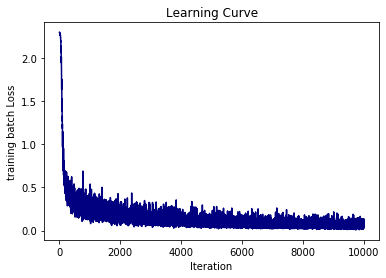

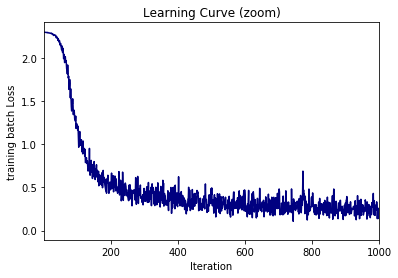

In [9]:
# ↑のSGD での train loss の推移を描画

plt.plot(range(1, iters_num+1), train_loss_list, "-", color="navy")
plt.xlabel("Iteration")
plt.ylabel("training batch Loss")
plt.title("Learning Curve")
plt.show()

plt.plot(range(1, iters_num+1), train_loss_list, "-", color="navy")
plt.xlabel("Iteration")
plt.ylabel("training batch Loss")
plt.title("Learning Curve (zoom)")
plt.xlim(1, 1000)
plt.show()


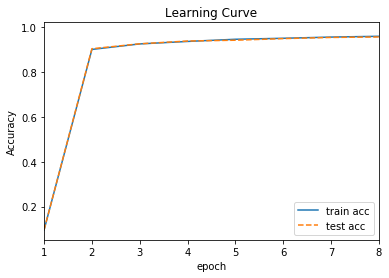

In [10]:
# 1エポックごとの train / test Accuracy を描画 (さっき標準出力したけど)

plt.plot(range(1, len(train_acc_list)+1), train_acc_list, "-", label="train acc")
plt.plot(range(1, len(test_acc_list)+1), test_acc_list, "--", label="test acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.xlim(1, 8)
plt.show()


In [43]:
%%time
# k-Nearest Neibhor Classifier と比較してみる． 計算重いからテストは軽く．ハイパラ k も適当

from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(x_train, np.argmax(t_train,axis=1))

pred = knc.predict(x_test[:1000, :])
print("Accuracy by kNN : " + str(np.mean(pred == np.argmax(t_test[:1000, :], axis=1))) )


Accuracy by kNN : 0.961
CPU times: user 1min 48s, sys: 735 ms, total: 1min 49s
Wall time: 1min 51s
